In [1]:
from utils.load_dataset import *
from utils.custom_utils import *

In [48]:
test_df = load_testing(test_txt)
test_dataset = FallenPeople(test_df, TESTING, FallenPeople.valid_test_transform())
#folder_path = "pred_new_inference_virtual_then_real/test_img"
model_path = "./models/checkpoint_train_real.pth"

In [49]:
def load_model(path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # create a Faster R-CNN model without pre-trained
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

    num_classes = 3 # wheat or not(background)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained model's head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    # load the trained weights
    #model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    # move model to the right device
    model.to(device)
    return model, device

In [50]:
model, device = load_model(model_path)
test_list = [random.randint(0,len(test_df['img_path'].unique())-1) for i in range(5)]

In [5]:
def take_prediction(prediction, threshold):
    boxes = prediction['boxes'].tolist()
    labels = prediction['labels'].tolist()
    scores = prediction['scores'].tolist()
    if len(boxes) == 0:
        return [([0,0,0,0],1,0.)]
    
    res = [t for t in zip(boxes,labels,scores) if t[2]>threshold]
    if len(res) == 0:
        res = [([0,0,0,0],1,0.)]
    return res

In [6]:
def visualize_prediction(dataset, list_imgs, model, device, path=None, thr=0.7):
    for l in list_imgs:
        img,target = dataset[l]
        with torch.no_grad():
            prediction = model([img.to(device)])
        p = take_prediction(prediction[0],thr)
        for bb,label,score in p:
            if label == 1:
                color = "green"
                text = f"no fallen: {score:.3f}"
            else:
                color = "red"
                text = f"fallen: {score:.3f}"
            x0,y0,x1,y1 = bb
            im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
            draw = ImageDraw.Draw(im)
            draw.rectangle(((x0, y0),(x1,y1)), outline=color, width=3)
            draw.text((x0, y0), text)
        if path is None:
            ImageShow.show(im)
        else:
            im.save(f'snapshots/{path}{l}.png')

In [25]:
def classifier_performance(dataset, model, device, fallen_or_not, tr = 0.7):
    tn, tp, fn, fp = 0,0,0,0
    for im,target in tqdm(dataset):
        gt_labels = target['labels'].tolist()
        with torch.no_grad():
            prediction = model([im.to(device)])
        p = take_prediction(prediction[0], tr)
        pred_labels = [l for _,l,_ in p]
        len_gt_lab = len(gt_labels)
        len_pred_lab = len(pred_labels)
        fall_gt = [i for i in gt_labels if i==fallen_or_not]
        num_fall_gt = len(fall_gt)
        num_no_fall_gt = len_gt_lab - num_fall_gt

        fall_pred = [i for i in pred_labels if i==fallen_or_not] 
        num_fall_pred = len(fall_pred)
        num_no_fall_pred = len_pred_lab - num_fall_pred

        if num_fall_gt == num_fall_pred:
            tp += num_fall_gt
        elif num_fall_gt > num_fall_pred:
            tp += num_fall_pred
            fn += (num_fall_gt - num_fall_pred)
        else:
            tp += num_fall_gt
            fp += (num_fall_pred - num_fall_gt)
    return tp, fp, fn

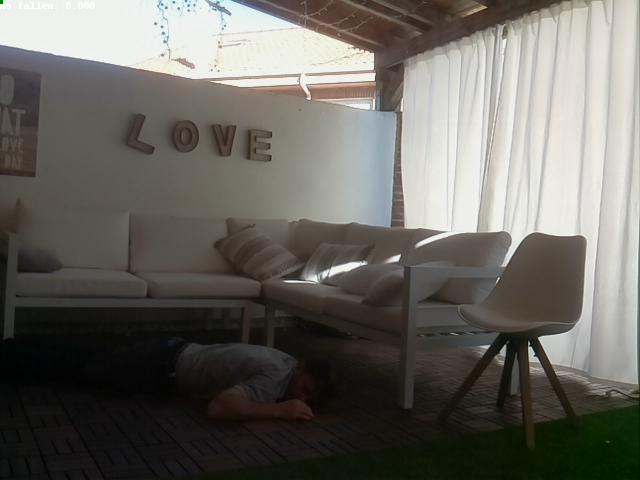

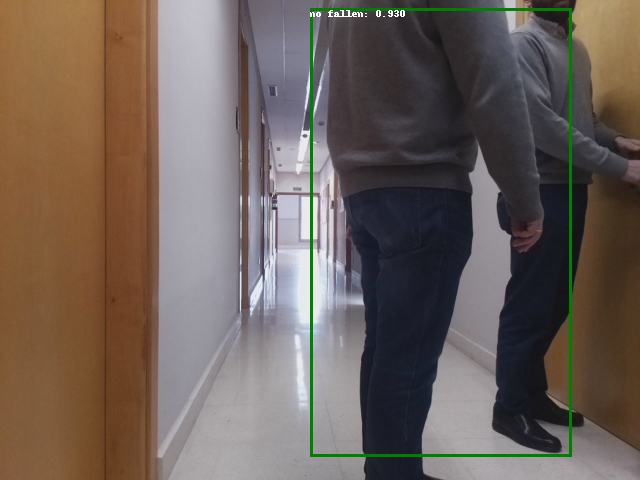

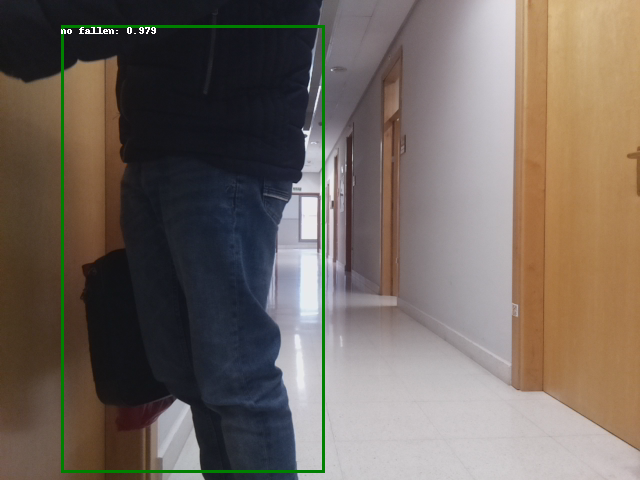

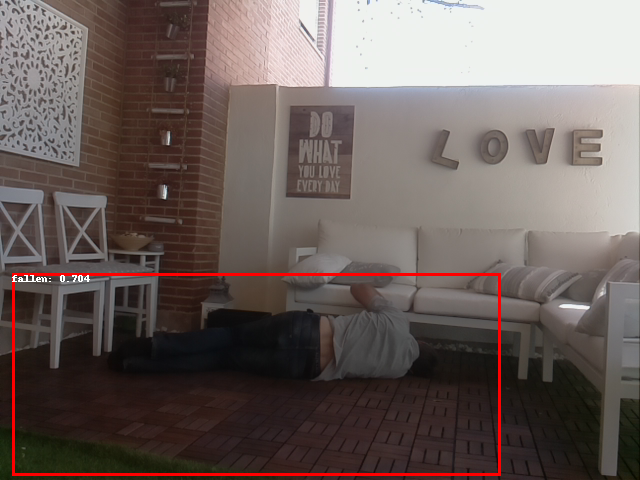

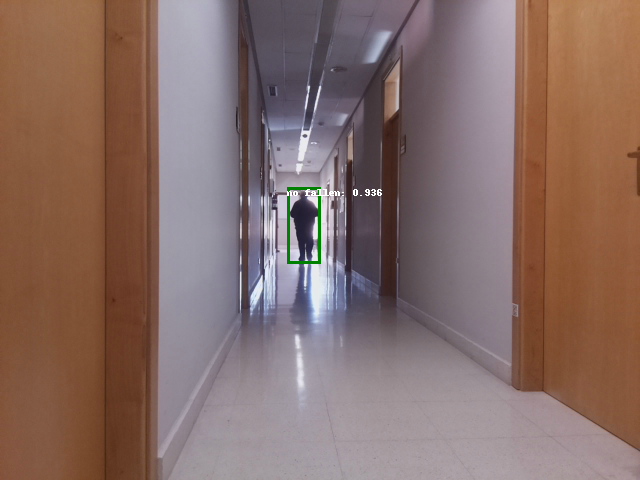

In [16]:
visualize_prediction(test_dataset, test_list, model, device)

In [17]:
true_pos, false_pos, false_neg = classifier_performance(test_dataset, model, device, 2)

100%|██████████| 959/959 [01:38<00:00,  9.71it/s]

TP: 354	FN: 37	FP: 61
Recall: 0.91
Precision: 0.85
F1-score: 0.88


In [18]:
true_pos_no_fall, false_pos_no_fall, false_neg_no_fall = classifier_performance(test_dataset, model, device, 1)

100%|██████████| 959/959 [01:40<00:00,  9.58it/s]

TP: 675	FN: 155	FP: 30
Recall: 0.81
Precision: 0.96
F1-score: 0.88


In [51]:
recall, precision, f1_score = [],[],[]
for thr in range(0,10,1):
    tp, fp, fn = classifier_performance(test_dataset, model, device, 2,float(thr/10))
    rec = tp / (tp+fn)
    prec = tp/ (tp+fp)
    f1_s = 2/((1/rec)+(1/prec))
    recall.append(f"{rec:.2f}")
    precision.append(f"{prec:.2f}")
    f1_score.append(f"{f1_s:.2f}")
    print(f"TP: {tp}\tFN: {fn}\tFP: {fp}")
    print(f"Recall: {rec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1-score: {f1_s:.2f}")

100%|██████████| 959/959 [01:38<00:00,  9.75it/s]


TP: 391	FN: 0	FP: 523
Recall: 1.00
Precision: 0.43
F1-score: 0.60


100%|██████████| 959/959 [01:41<00:00,  9.49it/s]


TP: 391	FN: 0	FP: 253
Recall: 1.00
Precision: 0.61
F1-score: 0.76


100%|██████████| 959/959 [01:41<00:00,  9.44it/s]


TP: 391	FN: 0	FP: 106
Recall: 1.00
Precision: 0.79
F1-score: 0.88


100%|██████████| 959/959 [01:41<00:00,  9.40it/s]


TP: 385	FN: 6	FP: 59
Recall: 0.98
Precision: 0.87
F1-score: 0.92


100%|██████████| 959/959 [01:41<00:00,  9.42it/s]


TP: 381	FN: 10	FP: 37
Recall: 0.97
Precision: 0.91
F1-score: 0.94


100%|██████████| 959/959 [01:40<00:00,  9.51it/s]


TP: 380	FN: 11	FP: 28
Recall: 0.97
Precision: 0.93
F1-score: 0.95


100%|██████████| 959/959 [01:41<00:00,  9.44it/s]


TP: 377	FN: 14	FP: 20
Recall: 0.96
Precision: 0.95
F1-score: 0.96


100%|██████████| 959/959 [01:41<00:00,  9.42it/s]


TP: 374	FN: 17	FP: 11
Recall: 0.96
Precision: 0.97
F1-score: 0.96


100%|██████████| 959/959 [01:42<00:00,  9.36it/s]


TP: 371	FN: 20	FP: 5
Recall: 0.95
Precision: 0.99
F1-score: 0.97


100%|██████████| 959/959 [01:42<00:00,  9.34it/s]

TP: 355	FN: 36	FP: 3
Recall: 0.91
Precision: 0.99
F1-score: 0.95


In [52]:
print(recall)
print(precision)
print(f1_score)

['1.00', '1.00', '1.00', '0.98', '0.97', '0.97', '0.96', '0.96', '0.95', '0.91']
['0.43', '0.61', '0.79', '0.87', '0.91', '0.93', '0.95', '0.97', '0.99', '0.99']
['0.60', '0.76', '0.88', '0.92', '0.94', '0.95', '0.96', '0.96', '0.97', '0.95']


In [32]:
print(recall)
print(precision)
print(f1_score)

['0.99', '0.99', '0.99', '0.98', '0.97', '0.95', '0.93', '0.91', '0.85', '0.78']
['0.31', '0.43', '0.57', '0.66', '0.74', '0.79', '0.83', '0.85', '0.91', '0.96']
['0.48', '0.60', '0.73', '0.79', '0.84', '0.86', '0.88', '0.88', '0.88', '0.86']


In [4]:
!pip install seaborn

     |################################| 292 kB 7.1 MB/s            


In [5]:
import seaborn as sns

sns.set_style("darkgrid")

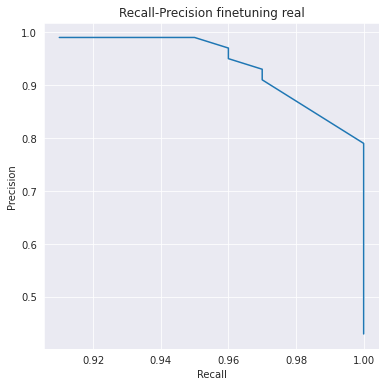

In [10]:
recall = [1.00, 1.00, 1.00, 0.98, 0.97, 0.97, 0.96, 0.96, 0.95, 0.91]
precision = [0.43, 0.61, 0.79, 0.87, 0.91, 0.93, 0.95, 0.97, 0.99, 0.99]
f1 = ['0.60', '0.76', '0.88', '0.92', '0.94', '0.95', '0.96', '0.96', '0.97', '0.95']

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall, precision, label='Recall - Precision')
#baseline = len(y_test[y_test==1]) / len(y_test)
#ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.title("Recall-Precision finetuning real")
plt.savefig("snapshots/plots/recall_precision_real.png")
plt.show()

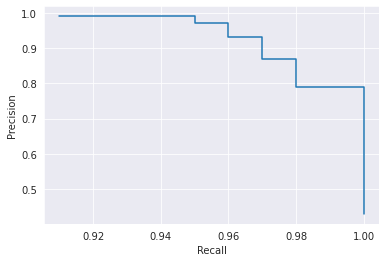

AUC-PR: 0.08429999999999997


In [16]:
from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay, auc)

disp1 = PrecisionRecallDisplay(precision=precision, recall=recall)
disp1.plot()

plt.show()

print(f'AUC-PR: {auc(recall, precision)}')

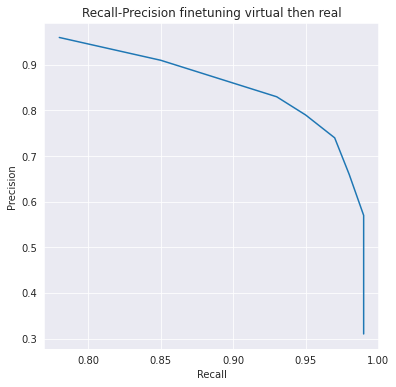

In [11]:
recall2 = ['0.99', '0.99', '0.99', '0.98', '0.97', '0.95', '0.93', '0.91', '0.85', '0.78']
precision2 = ['0.31', '0.43', '0.57', '0.66', '0.74', '0.79', '0.83', '0.85', '0.91', '0.96']

recall2 = [float(x) for x in recall2]
precision2 = [float(x) for x in precision2]

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.plot(recall2, precision2, label='Recall - Precision')
#baseline = len(y_test[y_test==1]) / len(y_test)
#ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
plt.title("Recall-Precision finetuning virtual then real")
plt.savefig("snapshots/plots/recall_precision_virtual_than_real.png")
plt.show()

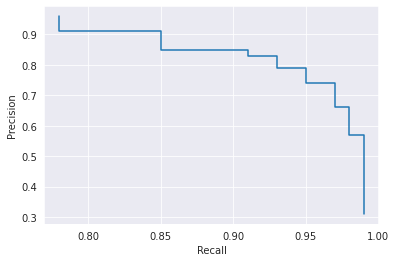

AUC-PR: 0.18


In [13]:
disp = PrecisionRecallDisplay(precision=precision2, recall=recall2)
disp.plot()

plt.show()

print(f'AUC-PR: {round(auc(recall2, precision2),2)}')